In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))
# atg_obs_selected = atg_obs.loc[(atg_obs['datetime_UTC']>=dt.datetime(2020,5,1))].copy() # Selecting dates

In [3]:
atg_obs_selected = atg_obs.copy() # Selecting dates

In [4]:
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2023,5,1))]

In [5]:
atg_obs_selected

,datetime_UTC,Pseudo-Julian-Date,Date,Time,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure,Solar,SumRain,Rain
12384156,2023-05-01 17:14:00,2.460067e+06,2023-05-01,17:14,54.600000,41.800000,61.8,4.000000,5.300000,246,1007.6,246.9,926.28,0.00
12384157,2023-05-01 17:15:00,2.460067e+06,2023-05-01,17:15,54.600000,41.800000,61.9,6.000000,8.900000,249,1007.9,236.4,926.28,0.00
12384158,2023-05-01 17:16:00,2.460067e+06,2023-05-01,17:16,54.500000,41.800000,62.1,7.600000,9.800000,249,1007.7,216.3,926.28,0.00
12384159,2023-05-01 17:17:00,2.460067e+06,2023-05-01,17:17,54.200000,41.900000,63.1,5.400000,7.000000,296,1007.9,203.8,926.28,0.00
12384160,2023-05-01 17:18:00,2.460067e+06,2023-05-01,17:18,54.200000,42.100000,63.5,6.300000,7.100000,264,1007.7,198.2,926.28,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941709,2024-05-23 17:52:00,2.460455e+06,2024-05-23,17:52,54.200000,42.000000,63.1,7.400000,10.800000,143,1017.2,225.6,969.65,0.00
12941710,2024-05-23 17:53:00,2.460455e+06,2024-05-23,17:53,54.200000,41.900000,63.0,12.300000,15.300000,153,1017.2,224.1,969.65,0.00
12941711,2024-05-23 17:54:00,2.460455e+06,2024-05-23,17:54,54.200000,41.800000,62.7,12.600000,14.400000,147,1017.2,223.6,969.65,0.00
12941712,2024-05-23 17:55:00,2.460455e+06,2024-05-23,17:55,54.100000,41.900000,63.1,10.700000,12.600000,125,1017.2,225.3,969.65,0.00


In [6]:
no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()
no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

In [7]:
no_erros_obs

,datetime_UTC,Pseudo-Julian-Date,Date,Time,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure,Solar,SumRain,Rain
12384156,2023-05-01 17:14:00,2.460067e+06,2023-05-01,17:14,54.6,41.800000,61.8,4.000000,5.300000,246,1007.6,246.9,926.28,0.0
12384157,2023-05-01 17:15:00,2.460067e+06,2023-05-01,17:15,54.6,41.800000,61.9,6.000000,8.900000,249,1007.9,236.4,926.28,0.0
12384158,2023-05-01 17:16:00,2.460067e+06,2023-05-01,17:16,54.5,41.800000,62.1,7.600000,9.800000,249,1007.7,216.3,926.28,0.0
12384159,2023-05-01 17:17:00,2.460067e+06,2023-05-01,17:17,54.2,41.900000,63.1,5.400000,7.000000,296,1007.9,203.8,926.28,0.0
12384160,2023-05-01 17:18:00,2.460067e+06,2023-05-01,17:18,54.2,42.100000,63.5,6.300000,7.100000,264,1007.7,198.2,926.28,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941709,2024-05-23 17:52:00,2.460455e+06,2024-05-23,17:52,54.2,42.000000,63.1,7.400000,10.800000,143,1017.2,225.6,969.65,0.0
12941710,2024-05-23 17:53:00,2.460455e+06,2024-05-23,17:53,54.2,41.900000,63.0,12.300000,15.300000,153,1017.2,224.1,969.65,0.0
12941711,2024-05-23 17:54:00,2.460455e+06,2024-05-23,17:54,54.2,41.800000,62.7,12.600000,14.400000,147,1017.2,223.6,969.65,0.0
12941712,2024-05-23 17:55:00,2.460455e+06,2024-05-23,17:55,54.1,41.900000,63.1,10.700000,12.600000,125,1017.2,225.3,969.65,0.0


In [8]:
first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='1h')
first_obs_each_period

In [9]:
summed_rain_each_period = first_obs_each_period['Rain'].sum()
summed_rain_each_period

datetime_UTC
2023-05-01 17:00:00    0.0
2023-05-01 18:00:00    0.0
2023-05-01 19:00:00    0.0
2023-05-01 20:00:00    0.0
2023-05-01 21:00:00    0.0
                      ... 
2024-05-23 13:00:00    0.0
2024-05-23 14:00:00    0.0
2024-05-23 15:00:00    0.0
2024-05-23 16:00:00    0.0
2024-05-23 17:00:00    0.0
Freq: h, Name: Rain, Length: 9313, dtype: float64

In [10]:
summed_rain_each_period[-48:-24]

datetime_UTC
2024-05-21 18:00:00    0.08
2024-05-21 19:00:00    0.06
2024-05-21 20:00:00    0.00
2024-05-21 21:00:00    0.01
2024-05-21 22:00:00    0.05
2024-05-21 23:00:00    0.09
2024-05-22 00:00:00    0.09
2024-05-22 01:00:00    0.03
2024-05-22 02:00:00    0.00
2024-05-22 03:00:00    0.00
2024-05-22 04:00:00    0.00
2024-05-22 05:00:00    0.00
2024-05-22 06:00:00    0.00
2024-05-22 07:00:00    0.00
2024-05-22 08:00:00    0.02
2024-05-22 09:00:00    0.15
2024-05-22 10:00:00    0.11
2024-05-22 11:00:00    0.07
2024-05-22 12:00:00    0.00
2024-05-22 13:00:00    0.00
2024-05-22 14:00:00    0.00
2024-05-22 15:00:00    0.00
2024-05-22 16:00:00    0.00
2024-05-22 17:00:00    0.00
Freq: h, Name: Rain, dtype: float64

In [11]:
lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.06)&(summed_rain_each_period>0.0)]
moderaterainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.15)&(summed_rain_each_period>0.06)]
heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.15)]

any_rainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]

summed_rain_each_period.loc[lightrainfall_times.index] = 1
summed_rain_each_period.loc[moderaterainfall_times.index] = 2
summed_rain_each_period.loc[heavyrainfall_times.index] = 3
# summed_rain_each_period.loc[any_rainfall_times.index] = 1

In [12]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary = pd.DataFrame()
atg_obs_necessary['date'] = first_obs_each_period['Date'].first()
atg_obs_necessary['time'] = first_obs_each_period['Time'].first()
atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
atg_obs_necessary['rainfall_type'] = summed_rain_each_period

data_arr = atg_obs_necessary.values
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-01 17:00:00,2023-05-01,17:14,54.6,1007.6,61.8,0.0
2023-05-01 18:00:00,2023-05-01,18:00,55.2,1007.5,62.4,0.0
2023-05-01 19:00:00,2023-05-01,19:00,55.0,1007.4,63.7,0.0
2023-05-01 20:00:00,2023-05-01,20:00,56.4,1006.8,63.2,0.0
2023-05-01 21:00:00,2023-05-01,21:00,56.8,1006.9,63.1,0.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,13:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,14:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,15:00,52.4,1017.0,69.1,0.0


In [13]:
atg_obs_necessary = atg_obs_necessary.dropna()

In [14]:
atg_obs_necessary.iloc[len(atg_obs_necessary)-14:,:]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2024-05-23 04:00:00,2024-05-23,04:00,57.5,1014.0,63.1,0.0
2024-05-23 05:00:00,2024-05-23,05:00,56.9,1014.5,65.3,0.0
2024-05-23 06:00:00,2024-05-23,06:00,56.4,1014.8,67.0,0.0
2024-05-23 07:00:00,2024-05-23,07:00,54.9,1014.7,69.5,0.0
2024-05-23 08:00:00,2024-05-23,08:00,52.6,1015.3,73.4,0.0
2024-05-23 09:00:00,2024-05-23,09:00,50.9,1015.9,77.4,0.0
2024-05-23 10:00:00,2024-05-23,10:00,50.6,1016.2,77.7,0.0
2024-05-23 11:00:00,2024-05-23,11:00,51.1,1016.3,76.7,0.0
2024-05-23 12:00:00,2024-05-23,12:00,50.2,1016.3,78.6,0.0


In [15]:
atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']==2]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-05 10:00:00,2023-05-05,10:00,49.0,1005.1,94.7,2.0
2023-05-05 17:00:00,2023-05-05,17:00,49.4,1006.7,91.7,2.0
2023-05-06 23:00:00,2023-05-06,23:00,58.0,1010.4,71.9,2.0
2023-06-10 08:00:00,2023-06-10,08:00,54.1,1013.4,93.5,2.0
2023-06-17 02:00:00,2023-06-17,02:00,59.3,1016.1,92.5,2.0
...,...,...,...,...,...,...
2024-05-21 23:00:00,2024-05-21,23:00,52.6,1010.5,91.7,2.0
2024-05-22 00:00:00,2024-05-22,00:00,52.4,1010.1,92.1,2.0
2024-05-22 09:00:00,2024-05-22,09:00,47.1,1006.1,88.4,2.0


In [16]:
notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=3].index

relevant_events = pd.DataFrame()
for event_time in notable_event_times:
    start_time = event_time-pd.Timedelta(days=30)
    end_time = event_time+pd.Timedelta(days=30)
    time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
    relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-20 09:00:00,2023-05-20,09:00,62.8,1015.4,61.1,0.0
2023-05-20 10:00:00,2023-05-20,10:00,62.0,1015.8,64.9,0.0
2023-05-20 11:00:00,2023-05-20,11:00,61.8,1015.7,62.8,0.0
2023-05-20 12:00:00,2023-05-20,12:00,60.8,1016.0,64.2,0.0
2023-05-20 13:00:00,2023-05-20,13:00,59.7,1016.4,69.5,0.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,13:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,14:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,15:00,52.4,1017.0,69.1,0.0


In [17]:
# notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=2].index

# relevant_times = pd.DataFrame()
# for event_time in notable_event_times:
#     start_time = max(event_time-pd.Timedelta(days=30), atg_obs_necessary.index[0])
#     end_time = min(event_time+pd.Timedelta(days=30), atg_obs_necessary.index[-1])

#     if not((start_time in relevant_times.index)):
#         time_around_event = start_time
#         relevant_events = atg_obs_necessary.loc[time_around_event-pd.Timedelta(hours=3):time_around_event+pd.Timedelta(hours=3)].copy()
#         relevant_times = pd.concat([relevant_times, relevant_events])

#     if not((event_time in relevant_times.index)):
#         time_around_event = event_time
#         relevant_events = atg_obs_necessary.loc[time_around_event-pd.Timedelta(hours=24):time_around_event+pd.Timedelta(hours=24)].copy()
#         relevant_times = pd.concat([relevant_times, relevant_events])

#     if not((end_time in relevant_times.index)):
#         time_around_event = end_time
#         relevant_events = atg_obs_necessary.loc[time_around_event-pd.Timedelta(hours=3):time_around_event+pd.Timedelta(hours=3)].copy()
#         relevant_times = pd.concat([relevant_times, relevant_events])

# relevant_times

In [18]:
notable_event_times

DatetimeIndex(['2023-06-19 09:00:00', '2023-09-26 01:00:00',
               '2023-09-27 15:00:00', '2023-10-11 03:00:00',
               '2023-10-11 04:00:00', '2023-11-02 08:00:00',
               '2023-11-02 13:00:00', '2023-11-04 05:00:00',
               '2023-11-04 14:00:00', '2023-11-04 17:00:00',
               '2023-11-07 00:00:00', '2023-12-02 10:00:00',
               '2023-12-05 03:00:00', '2023-12-05 06:00:00',
               '2023-12-05 07:00:00', '2023-12-05 08:00:00',
               '2023-12-05 09:00:00', '2023-12-05 12:00:00',
               '2023-12-07 15:00:00', '2023-12-22 16:00:00',
               '2023-12-26 07:00:00', '2024-01-17 18:00:00',
               '2024-02-15 09:00:00', '2024-02-29 07:00:00',
               '2024-04-29 11:00:00', '2024-05-07 07:00:00'],
              dtype='datetime64[ns]', name='datetime_UTC', freq=None)

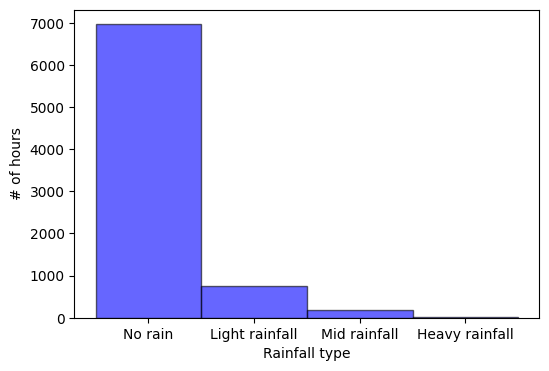

(array([6963,  747,  187,   26]), array([0., 1., 2., 3., 4.]))

In [19]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [20]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M')

    days_of_year = pd.DatetimeIndex(date_objs).dayofyear
    months = pd.DatetimeIndex(date_objs).month
    times_in_hours_from_zero = (pd.DatetimeIndex(time_objs).hour + (pd.DatetimeIndex(time_objs).minute/60))
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = (np.abs(months - 7))
    # processed_df['month'] = months
    processed_df['time_of_day'] = ((hours-8)%24) // 6
    # processed_df['days_of_year'] = days_of_year
    # processed_df['times_in_hours_from_zero'] = times_in_hours_from_zero

    vals = dataset['temperature']
    # med_val = vals.median()
    # dif_vals = np.abs(vals-med_val)
    # max_normval = dif_vals.max()
    # norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    # med_val = vals.median()
    # dif_vals = np.abs(vals-med_val)
    # max_normval = dif_vals.max()
    # norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    # med_val = vals.median()
    # dif_vals = np.abs(vals-med_val)
    # max_normval = dif_vals.max()
    # norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [21]:
def create_oversampled_df(processed_df):
    num_zeros = processed_df[processed_df['class']==0].shape[0]

    zeros_samps = processed_df[processed_df['class']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 4):
        under_group_samps = processed_df[processed_df['class']==group].copy()
        group_samps = under_group_samps.sample(n=num_zeros, replace=True, random_state=42)
        np.random.seed(42)
        noise = np.random.normal(0,1,num_zeros)
        group_samps['feature_1'] = group_samps['feature_1']+noise
        group_samps['feature_2'] = group_samps['feature_2']+noise
        group_samps['feature_3'] = group_samps['feature_3']+noise
        dupl_processed_df = pd.concat([dupl_processed_df, group_samps])

    return dupl_processed_df

In [22]:
under_sam_reltimes = get_processed_df_from_data(relevant_events)

In [23]:
relevant_times = create_oversampled_df(under_sam_reltimes)
relevant_times

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
0,2,0,62.800000,61.100000,1015.400000,0.0
1,2,0,62.000000,64.900000,1015.800000,0.0
2,2,0,61.800000,62.800000,1015.700000,0.0
3,2,0,60.800000,64.200000,1016.000000,0.0
4,2,0,59.700000,69.500000,1016.400000,0.0
...,...,...,...,...,...,...
2524,3,3,57.666905,94.866905,997.066905,3.0
3849,5,0,58.797156,96.497156,1007.297156,3.0
3061,4,0,54.416681,99.016681,1003.216681,3.0
3848,5,0,59.332095,95.032095,1008.232095,3.0


In [24]:
processed_df_train_val, processed_df_test = train_test_split(relevant_times,random_state=42,test_size=0.2)

In [25]:
processed_df_train, processed_df_val = train_test_split(processed_df_train_val,random_state=42,test_size=0.25)

In [26]:
processed_df_train

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
2596,3,3,59.390058,80.190058,1009.390058,1.0
2140,2,3,58.066967,89.466967,1004.966967,2.0
3856,5,1,55.318215,89.918215,1008.518215,2.0
4262,5,1,45.482571,94.482571,1008.482571,2.0
1413,0,3,63.800000,63.000000,1017.600000,0.0
...,...,...,...,...,...,...
5639,5,2,53.600000,31.100000,1008.100000,0.0
753,1,1,54.510960,87.510960,1017.910960,1.0
3872,5,0,49.981158,97.281158,1009.581158,1.0
3611,4,0,35.400000,89.200000,1024.600000,0.0


In [27]:
processed_df_val

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
5904,5,2,49.336839,88.736839,995.636839,2.0
3103,4,3,53.772280,95.272280,1005.872280,2.0
3852,5,0,59.816340,94.216340,1008.416340,3.0
3959,5,2,36.594844,94.394844,1016.394844,1.0
494,1,2,54.064883,88.764883,1012.964883,1.0
...,...,...,...,...,...,...
4277,5,3,42.400000,93.100000,1018.100000,0.0
5577,5,0,36.532608,95.232608,1005.532608,3.0
4341,5,2,43.312431,89.612431,1010.812431,2.0
3908,5,2,46.112300,86.812300,1005.812300,2.0


In [28]:
processed_df_test

,months_from_july,time_of_day,feature_1,feature_2,feature_3,class
6011,4,0,37.497788,92.897788,1005.097788,1.0
5129,6,1,51.256240,98.356240,1012.956240,2.0
4264,5,1,46.807803,94.107803,1008.807803,3.0
4885,6,0,34.601653,95.501653,995.401653,1.0
5138,6,3,57.396874,90.996874,1013.796874,2.0
...,...,...,...,...,...,...
3869,5,3,49.921163,94.121163,1009.221163,1.0
2495,3,2,62.352678,78.352678,999.452678,1.0
5905,5,2,48.550642,91.550642,994.450642,2.0
4894,6,2,35.418844,92.418844,998.418844,1.0


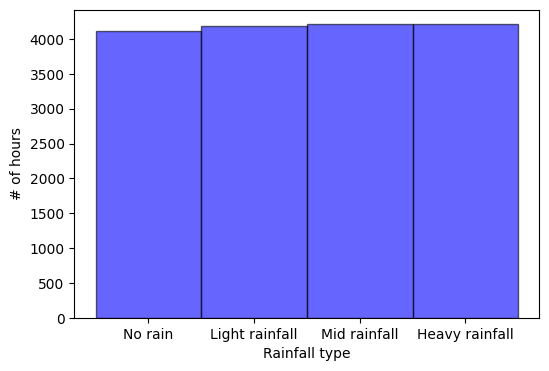

(array([4108, 4182, 4210, 4210]), array([0., 1., 2., 3., 4.]))

In [29]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

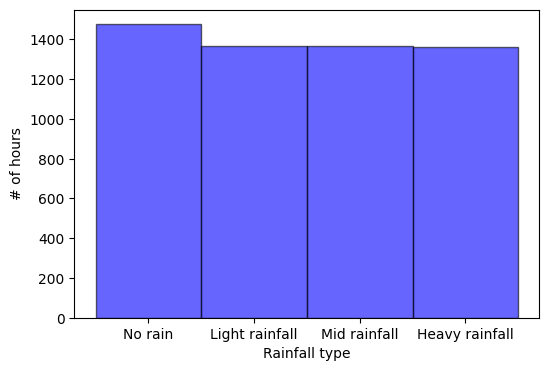

(array([1476, 1368, 1365, 1362]), array([0., 1., 2., 3., 4.]))

In [30]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

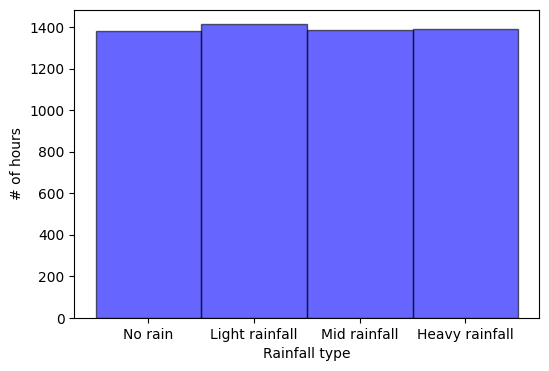

(array([1379, 1413, 1388, 1391]), array([0., 1., 2., 3., 4.]))

In [31]:
rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [32]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train = processed_data_train[~np.isnan(processed_data_train).any(axis=1)]
processed_data_train.shape

(16710, 6)

In [33]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val = processed_data_val[~np.isnan(processed_data_val).any(axis=1)]
processed_data_val.shape

(5571, 6)

In [34]:
processed_data_test = processed_df_test.values.astype(float)
processed_data_test = processed_data_test[~np.isnan(processed_data_test).any(axis=1)]
processed_data_test.shape

(5571, 6)

In [35]:
print(f'Data Shape: {data_arr.shape}')
print(f'Data Entry: [Month, Time of Day, Temperature, Relative Humidity, Pressure, Rain type]')

# Pre-Processed
print(data_arr[0])

# Post-Processed
print(processed_data_train[0])
print(processed_data_val[0])
print(processed_data_test[0])

Data Shape: (9313, 6)
Data Entry: [Month, Time of Day, Temperature, Relative Humidity, Pressure, Rain type]
['2023-05-01' '17:14' 54.6 1007.6 61.8 0.0]
[3.00000000e+00 3.00000000e+00 5.93900577e+01 8.01900577e+01
 1.00939006e+03 1.00000000e+00]
[  5.           2.          49.33683864  88.73683864 995.63683864
   2.        ]
[4.00000000e+00 0.00000000e+00 3.74977883e+01 9.28977883e+01
 1.00509779e+03 1.00000000e+00]


In [36]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_data_train = processed_data_train[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_train[0], y_data_train[0])

[   3.            3.           59.39005773   80.19005773 1009.39005773] [1]


In [37]:
x_data_val = processed_data_val[:, :processed_data_train.shape[1]-1]
y_data_val = processed_data_val[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_val[0], y_data_val[0])

[  5.           2.          49.33683864  88.73683864 995.63683864] [2]


In [38]:
x_data_test = processed_data_test[:, :processed_data_train.shape[1]-1]
y_data_test = processed_data_test[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_test[0], y_data_test[0])

[   4.            0.           37.49778831   92.89778831 1005.09778831] [1]


In [39]:
# # Assuming X is your feature matrix and y is your target vector
# # First split: train+val and test
# X_train_val, X_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# # Second split: train and val
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# # Now you have X_train, X_val, X_test, y_train, y_val, y_test
# print(f"Training set size: {X_train.shape[0]}")
# print(f"Validation set size: {X_val.shape[0]}")
# print(f"Test set size: {X_test.shape[0]}")

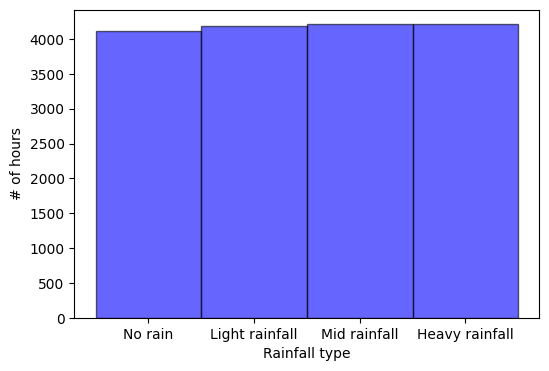

(array([4108, 4182, 4210, 4210]), array([0, 1, 2, 3, 4]))

In [40]:
rain_counts, classes = np.histogram(y_data_train, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [41]:
# smote = SMOTE(random_state = 42, sampling_strategy={0:8000, 1:8000, 2:8000, 3:8000})
# x_train_res, y_train_res = smote.fit_resample(x_data_train, y_data_train.ravel())

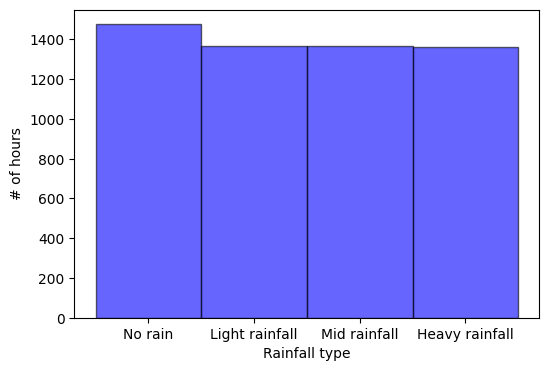

(array([1476, 1368, 1365, 1362]), array([0, 1, 2, 3, 4]))

In [42]:
rain_counts, classes = np.histogram(y_data_val, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [43]:
# x, y = smote.fit_resample(processed_df_val, y_data_val.ravel())
# x[x['class']==3][:20]

In [44]:
# smote = SMOTE(random_state = 42, sampling_strategy={0:8000, 1:8000, 2:8000, 3:8000})
# x_val_res, y_val_res = smote.fit_resample(x_data_val, y_data_val.ravel())

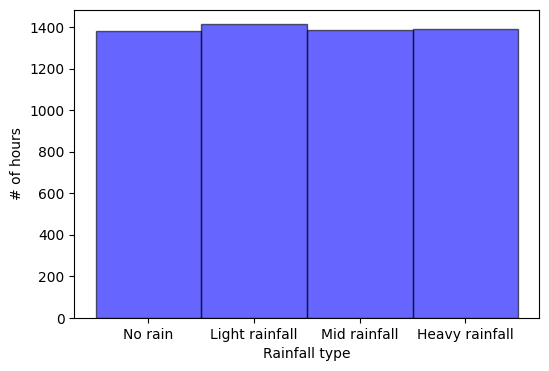

(array([1379, 1413, 1388, 1391]), array([0, 1, 2, 3, 4]))

In [45]:
rain_counts, classes = np.histogram(y_data_test, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [46]:
# smote = SMOTE(random_state = 42, sampling_strategy={0:8000, 1:8000, 2:8000, 3:8000})
# x_test_res, y_test_res = smote.fit_resample(x_data_test, y_data_test.ravel()) 

In [47]:
# rain_counts, classes = np.histogram(y_train_res, bins=np.arange(0,y_train_res.max()+2))

# plt.figure(figsize=(6,4))
# # plt.title(f'Hours where it rained at least {rain_thresh} inches')
# plt.bar(x=np.arange(0,y_train_res.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# # plt.xticks(np.arange(0,4))
# plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,y_train_res.max()+1), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
# plt.xlabel('Rainfall type')
# plt.show()
# rain_counts, classes

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(5,)))

# Hidden layers
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model summary
model.summary()

2024-05-25 01:29:33.915096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 01:29:33.915303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,596
Trainable params: 2,596
Non-trainable params: 0
___________________________________________

In [49]:
X_train_scaled.shape, y_data_train.shape

((16710, 5), (16710, 1))

In [50]:
X_val_scaled.shape, y_data_val.shape

((5571, 5), (5571, 1))

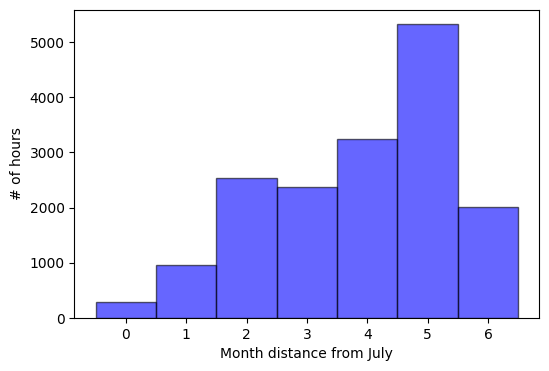

(array([ 281,  959, 2535, 2366, 3243, 5323, 2003]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [51]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [52]:
X_train_scaled

array([[-0.57419184,  1.29041017,  1.06080451, -0.29338839,  0.19560371],
       [-1.23127618,  1.29041017,  0.89298009,  0.3963793 , -0.39056017],
       [ 0.73997685, -0.43502425,  0.54432098,  0.42993105,  0.08006403],
       ...,
       [ 0.73997685, -1.29774146, -0.13264581,  0.97738926,  0.22092906],
       [ 0.08289251, -1.29774146, -1.9821595 ,  0.37652945,  2.21127994],
       [ 0.73997685,  1.29041017, -0.45098406,  0.68669   , -1.88748272]])

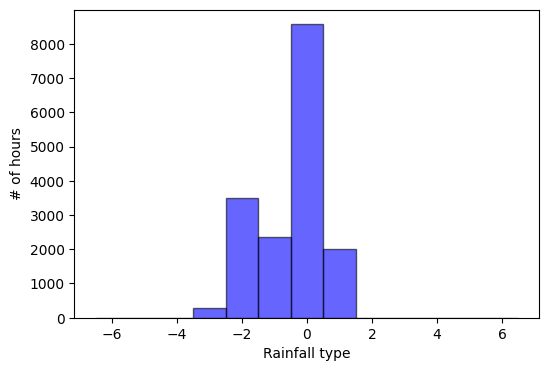

(array([   0,    0,    0,  281, 3494, 2366, 8566, 2003,    0,    0,    0,
           0,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [53]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [54]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-05-25 01:29:35.129808: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-25 01:29:35.357451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


523/523 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.4582

2024-05-25 01:29:42.597677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


523/523 [==============================] - 8s 10ms/step - loss: 1.1944 - accuracy: 0.4582 - val_loss: 1.0611 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 2/100
523/523 [==============================] - 5s 10ms/step - loss: 1.0720 - accuracy: 0.5243 - val_loss: 1.0200 - val_accuracy: 0.5496 - lr: 0.0010
Epoch 3/100
523/523 [==============================] - 4s 8ms/step - loss: 1.0345 - accuracy: 0.5439 - val_loss: 0.9941 - val_accuracy: 0.5516 - lr: 0.0010
Epoch 4/100
523/523 [==============================] - 5s 9ms/step - loss: 1.0051 - accuracy: 0.5637 - val_loss: 0.9718 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 5/100
523/523 [==============================] - 4s 8ms/step - loss: 0.9897 - accuracy: 0.5645 - val_loss: 0.9629 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 6/100
523/523 [==============================] - 4s 8ms/step - loss: 0.9732 - accuracy: 0.5744 - val_loss: 0.9476 - val_accuracy: 0.5931 - lr: 0.0010
Epoch 7/100
523/523 [==============================] - 7s 13ms/step - loss

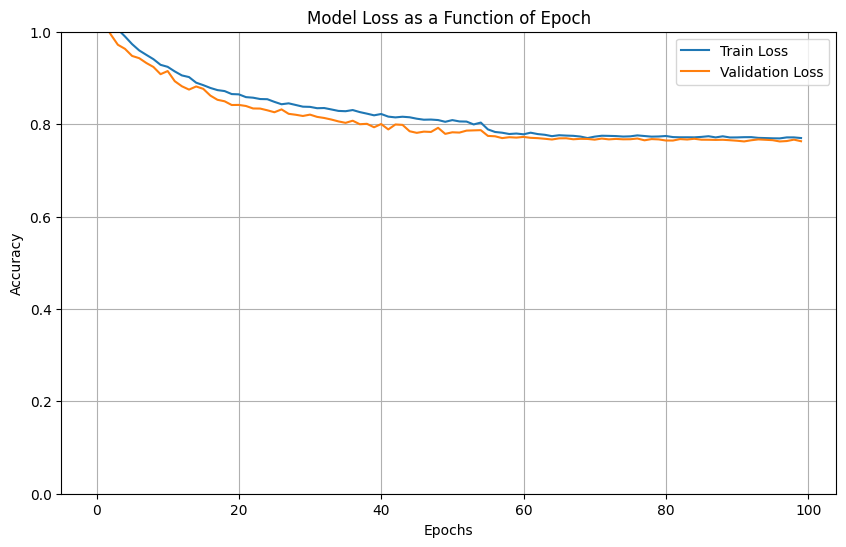

In [55]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

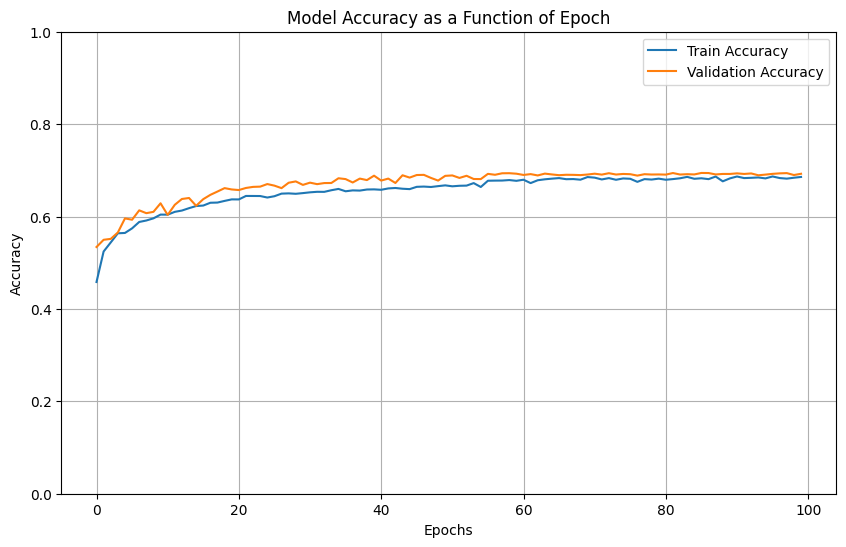

In [56]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

In [58]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test.ravel().astype(float), verbose=2)

 61/175 [=========>....................] - ETA: 0s

2024-05-25 01:37:40.235023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 0s 2ms/step


2024-05-25 01:37:40.804343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


175/175 - 1s - loss: 0.7748 - accuracy: 0.6853 - 971ms/epoch - 6ms/step


[0.7747736573219299, 0.6853347420692444]

Confusion Matrix:
[[ 988  253  117   21]
 [ 190  634  501   88]
 [ 175  259  811  143]
 [   0    0    6 1385]]


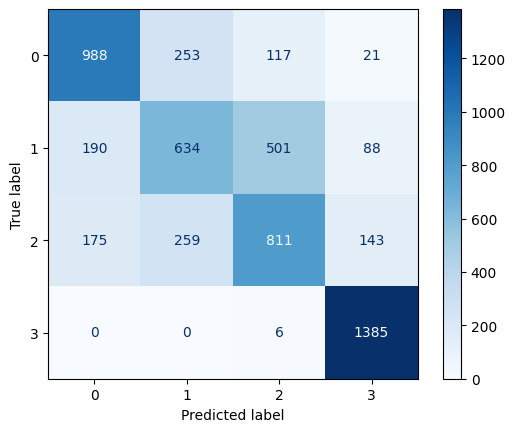

In [59]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[ 988  253  117   21]
 [ 190  634  501   88]
 [ 175  259  811  143]
 [   0    0    6 1385]]


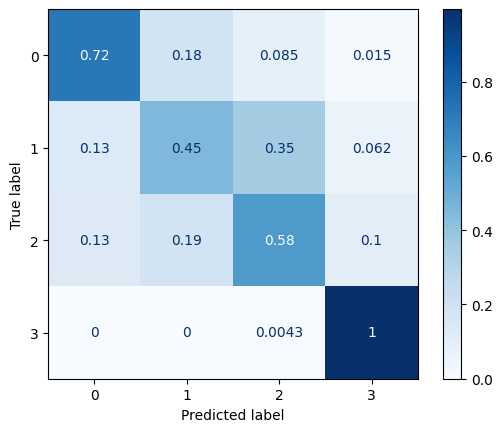

In [60]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(4, 1)), display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
f1_score(y_data_test.ravel(), np.argmax(predictions,axis=1), average=None)

array([0.72327965, 0.49550606, 0.57456606, 0.91479524])